<a href="https://colab.research.google.com/github/abhiramoggu/statistics-analysis/blob/main/STATFinalQ1v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

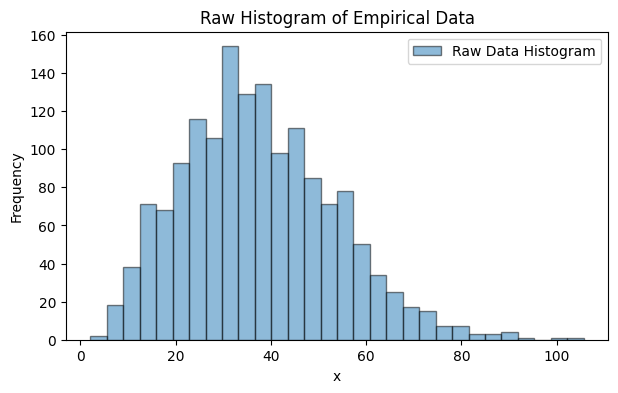

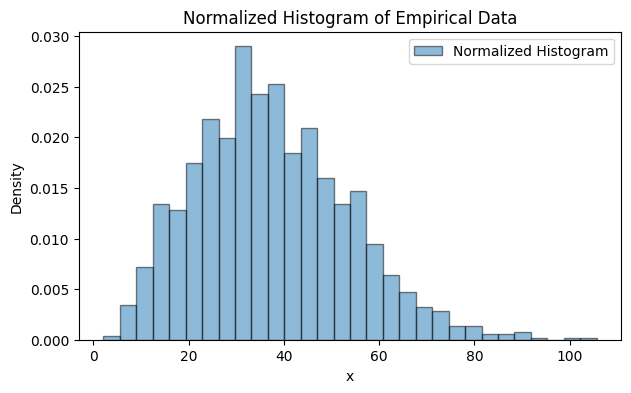

Data loaded. Number of points = 1540


In [ ]:
##############################################
# Snippet A: IMPORTS AND DATA LOADING
##############################################

import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# For SciPy optimization
from scipy.optimize import minimize

# For reproducibility in random sampling, bootstrapping, etc.
random.seed(123)
np.random.seed(123)

##############################################
# 1. LOAD DATA + PLOT HISTOGRAMS
##############################################

data_file = "data26002204680.csv"  # your CSV file path
data = []
with open(data_file, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        val = float(row[0])
        data.append(val)

data = np.array(data)
n = len(data)

# 1A. RAW HISTOGRAM
plt.figure(figsize=(7,4))
plt.hist(data, bins=30, alpha=0.5, edgecolor='k', label="Raw Data Histogram")
plt.title("Raw Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 1B. NORMALIZED HISTOGRAM
plt.figure(figsize=(7,4))
plt.hist(data, bins=30, density=True, alpha=0.5, edgecolor='k', label="Normalized Histogram")
plt.title("Normalized Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Data loaded. Number of points = {n}")


In [ ]:
##############################################
# Snippet B: DEFINE 10 CANDIDATE PDFs (Improved)
##############################################
def pdf1(x, alpha, beta):
    """
    PDF1: Stabilized for edge cases with safeguards against invalid inputs.
    """
    if alpha <= 0 or beta <= 0 or x <= 0:
        return 1e-10
    try:
        denom = 2.0 * alpha * np.sqrt(2.0 * np.pi * beta) * (x ** 1.5)
        exponent = -((x - beta) ** 2) / (2.0 * (alpha ** 2) * beta * x)
        val = (np.exp(exponent) * (x + beta)) / denom
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf2(x, c, k, b):
    """
    PDF2: Generalized distribution with parameter safeguards.
    """
    if c <= 0 or k <= 0 or b <= 0 or x <= 0:
        return 1e-10
    try:
        numerator = (c * k) * (x ** (c * k - 1.0))
        denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
        if denominator <= 0:
            return 1e-10
        val = numerator / denominator
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf3(x, mu, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        coeff = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
        term1 = np.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))
        term2 = np.exp(-((x + mu) ** 2) / (2.0 * sigma ** 2))
        val = coeff * (term1 + term2)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf4(x, c, sigma):
    if c <= 0 or sigma <= 0 or x <= 0:
        return 1e-10
    try:
        val = (c / x) * ((x / sigma) ** (-c)) * np.exp(-((x / sigma) ** (-c)))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf5(x, lam, mu):
    if lam <= 0 or mu <= 0 or x <= 0:
        return 1e-10
    try:
        coeff = np.sqrt(lam / (2.0 * np.pi * (x ** 3)))
        exponent = -lam * ((x - mu) ** 2) / (2.0 * (mu ** 2) * x)
        val = coeff * np.exp(exponent)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf6(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        factor = np.sqrt(2.0 / np.pi) * (x ** 2) / (sigma ** 3)
        val = factor * np.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf7(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        val = (x / (sigma ** 2)) * np.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf8(x, c, b):
    if c <= 0 or b <= 0 or x < 0:
        return 1e-10
    try:
        val = (c * (x ** (c - 1.0)) * np.exp(-((x ** c) / (b ** c)))) / (b ** c)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf9(x, lam, mu):
    if lam <= 0 or mu <= 0 or x < 0:
        return 1e-10
    try:
        expr1 = np.exp(-x * lam)
        expr2 = expr1 * mu
        val = np.exp(-x * lam - expr2)
        bracket = lam * (1.0 + (1.0 - expr1) * mu)
        result = val * bracket
        return result if result > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf10(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        const = ((sigma ** 2) * (1.0 + x)) / (1.0 + sigma)
        exponent = -x * sigma
        val = const * np.exp(exponent)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

print("Improved PDFs defined.")

Improved PDFs defined.


In [ ]:
import math
import numpy as np
from scipy.optimize import minimize

##############################################
# Snippet D: NLL AND BASIC FIT (Gradient-based) FOR ALL MODELS
##############################################

# -------- Model #1 ---------------------------------------
def nll_1(params, data_array):
    alpha, beta = params
    # Safeguard: alpha,beta > 0
    if alpha <= 0 or beta <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf1(x, alpha, beta)
        if val <= 0:
            return np.inf  # invalid or zero PDF => infinite NLL
        total += -math.log(val)
    return total

def fit_pdf1_gradient(data_array):
    """
    Gradient-based fitting for Model #1.
    """
    init = [0.5, 33.0]  # Initial guesses
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_1(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #2 ---------------------------------------
def nll_2(params, data_array):
    c_, k_, b_ = params
    if c_ <= 0 or k_ <= 0 or b_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf2(x, c_, k_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf2_gradient(data_array):
    """
    Gradient-based fitting for Model #2.
    """
    init = [77.0, 78.0, 94.0]
    bnds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_2(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #3 ---------------------------------------
def nll_3(params, data_array):
    mu_, sigma_ = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf3(x, mu_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf3_gradient(data_array):
    """
    Gradient-based fitting for Model #3.
    """
    init = [37.0, 16.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_3(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #4 ---------------------------------------
def nll_4(params, data_array):
    c_, sigma_ = params
    if c_ <= 0 or sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf4(x, c_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf4_gradient(data_array):
    """
    Gradient-based fitting for Model #4.
    """
    init = [20.0, 76.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_4(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #5 ---------------------------------------
def nll_5(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf5(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf5_gradient(data_array):
    """
    Gradient-based fitting for Model #5.
    """
    init = [138.0, 37.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_5(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #6 ---------------------------------------
def nll_6(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf6(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf6_gradient(data_array):
    """
    Gradient-based fitting for Model #6.
    """
    init = [23.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_6(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #7 ---------------------------------------
def nll_7(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf7(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf7_gradient(data_array):
    """
    Gradient-based fitting for Model #7.
    """
    init = [28.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_7(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #8 ---------------------------------------
def nll_8(params, data_array):
    c_, b_ = params
    if c_ <= 0 or b_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf8(x, c_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf8_gradient(data_array):
    """
    Gradient-based fitting for Model #8.
    """
    init = [87.0, 67.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_8(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #9 ---------------------------------------
def nll_9(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf9(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf9_gradient(data_array):
    """
    Gradient-based fitting for Model #9.
    """
    init = [84.0, 82.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_9(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #10 --------------------------------------
def nll_10(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf10(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf10_gradient(data_array):
    """
    Gradient-based fitting for Model #10.
    """
    init = [94.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_10(p, data_array), init, bounds=bnds)
    return res.x, res.fun

print("NLL functions and gradient-based fits for all 10 models defined (no upper bound).")


NLL functions and gradient-based fits for all 10 models defined (no upper bound).


In [ ]:
##############################################
# Snippet E: SIMULATED ANNEALING (SA)
##############################################

def simulated_annealing(nll_func, init_params, data_array,
                        max_iter=2000, temp_start=10.0, temp_end=0.1, alpha=0.99):
    """
    Very minimal SA approach.
    :nll_func: a function nll_func(params, data)
    :init_params: initial guess
    :data_array: the dataset
    :max_iter: number of iterations
    :temp_start: starting temperature
    :temp_end: end temperature
    :alpha: decay rate per iteration
    """
    import copy

    current_params = np.array(init_params, dtype=np.float64)
    current_nll = nll_func(current_params, data_array)
    best_params = copy.deepcopy(current_params)
    best_nll = current_nll

    temp = temp_start

    for i in range(max_iter):
        # Generate new candidate (slight random perturbation)
        candidate = current_params + np.random.normal(0, 1, size=len(current_params))

        # Clip or enforce positivity if needed
        # e.g. candidate = np.clip(candidate, 1e-6, 1e6)

        cand_nll = nll_func(candidate, data_array)

        # If better, accept immediately
        if cand_nll < current_nll:
            current_params = candidate
            current_nll = cand_nll
            if cand_nll < best_nll:
                best_params = candidate
                best_nll = cand_nll
        else:
            # Accept with probability exp(-(cand_nll - current_nll) / temp)
            diff = cand_nll - current_nll
            prob = math.exp(-diff / temp)
            if np.random.rand() < prob:
                current_params = candidate
                current_nll = cand_nll

        # Cool down
        temp = max(temp_end, temp * alpha)

    return best_params, best_nll

print("Defined a simple simulated annealing function.")


Defined a simple simulated annealing function.


In [ ]:
##############################################
# Snippet F: HYBRID (SA + Gradient)
##############################################

def fit_hybrid(nll_func, init_params, data_array):
    # 1) Run simulated annealing
    sa_params, sa_nll = simulated_annealing(nll_func, init_params, data_array,
                                           max_iter=1000,
                                           temp_start=10.0, temp_end=0.01, alpha=0.98)
    # 2) Then refine with gradient-based
    res = minimize(lambda p: nll_func(p, data_array), sa_params)
    return res.x, res.fun

print("Defined a hybrid approach (SA + gradient).")


Defined a hybrid approach (SA + gradient).


In [ ]:
##############################################
# Snippet G: MULTI-START GRADIENT
##############################################

def fit_pdf_multi_start(nll_func, data_array, param_dims, tries=5):
    """
    param_dims: e.g. [(0.1, 5), (0.1, 10)] for 2D (alpha in [0.1..5], beta in [0.1..10])
    tries: how many random starts
    """
    best_params = None
    best_nll = np.inf

    for _ in range(tries):
        init_guess = []
        for (low, high) in param_dims:
            init_guess.append(np.random.uniform(low, high))

        res = minimize(lambda p: nll_func(p, data_array), init_guess)
        if res.fun < best_nll:
            best_nll = res.fun
            best_params = res.x

    return best_params, best_nll

print("Defined multi-start approach for trying a range of initial values.")


Defined multi-start approach for trying a range of initial values.


In [ ]:
##############################################
# Snippet H: COMPARE THREE METHODS FOR ALL 10 MODELS
##############################################

def model_nll_funcs():
    return {
        "Model #1": (nll_1, [(1e-3, 100), (1e-3, 100)]),
        "Model #2": (nll_2, [(1e-3, 100), (1e-3, 100), (1e-3, 100)]),
        "Model #3": (nll_3, [(1e-3, 100), (1e-3, 100)]),
        "Model #4": (nll_4, [(1e-3, 100), (1e-3, 100)]),
        "Model #5": (nll_5, [(1e-3, 100), (1e-3, 100)]),
        "Model #6": (nll_6, [(1e-3, 100)]),
        "Model #7": (nll_7, [(1e-3, 100)]),
        "Model #8": (nll_8, [(1e-3, 100), (1e-3, 100)]),
        "Model #9": (nll_9, [(1e-3, 100), (1e-3, 100)]),
        "Model #10": (nll_10, [(1e-3, 100)]),
    }

results = {}
model_funcs = model_nll_funcs()

for mname in model_funcs:
    print(f"\nOptimizing {mname}...")
    nll_func, param_dims = model_funcs[mname]

    # (a) Gradient
    best_g, best_nll_g = fit_pdf_multi_start(nll_func, data, param_dims, tries=5)
    print(f"  Gradient: Best Params = {best_g}, NLL = {best_nll_g:.6f}")

    # (b) Simulated Annealing
    init_random = [np.random.uniform(low, high) for (low, high) in param_dims]
    best_sa, best_nll_sa = simulated_annealing(nll_func, init_random, data)
    print(f"  Annealing: Best Params = {best_sa}, NLL = {best_nll_sa:.6f}")

    # (c) Hybrid
    best_hyb, best_nll_hyb = fit_hybrid(nll_func, init_random, data)
    print(f"  Hybrid: Best Params = {best_hyb}, NLL = {best_nll_hyb:.6f}")

    results[mname] = {
        'gradient': (best_g, best_nll_g),
        'annealing': (best_sa, best_nll_sa),
        'hybrid': (best_hyb, best_nll_hyb)
    }

print("\nAll models optimized with Gradient, Annealing, and Hybrid methods.")



Optimizing Model #1...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df

  Gradient: Best Params = [ 0.50350699 33.16891762], NLL = 6503.951038
  Annealing: Best Params = [ 0.49786933 33.14941075], NLL = 6504.149029
  Hybrid: Best Params = [ 0.50350699 33.16891655], NLL = 6503.951038

Optimizing Model #2...
  Gradient: Best Params = [11.19014115 61.09189844 23.27239722], NLL = 35459.810432


<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k) * (x ** (c * k - 1.0))
<ipython-input-129-8d3c59ccf50d>:26: RuntimeWarning: overflow encountered in scalar power
  denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
<ipython-input-129-8d3c59ccf50d>:29: RuntimeWarning: invalid value encountered in scalar divide
  val = numerator / denominator


  Annealing: Best Params = [77.01281156 78.69048653 93.9848156 ], NLL = 35459.810432
  Hybrid: Best Params = [77.01281156 78.69048653 93.9848156 ], NLL = 35459.810432

Optimizing Model #3...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [37.33446817 16.14301847], NLL = 6443.366142
  Annealing: Best Params = [37.3685879  16.19326889], NLL = 6443.383406
  Hybrid: Best Params = [-37.33450888  16.14297053], NLL = 6443.366142

Optimizing Model #4...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [77.03030948 76.0755355 ], NLL = 36281.711451
  Annealing: Best Params = [57.40415522 83.83399408], NLL = 36079.220229
  Hybrid: Best Params = [48.89398809 75.92227609], NLL = 38413.248505

Optimizing Model #5...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [138.80566173  37.42047048], NLL = 6515.080102
  Annealing: Best Params = [138.82892018  37.42689335], NLL = 6515.080197
  Hybrid: Best Params = [138.82649777  37.42059358], NLL = 6515.080109

Optimizing Model #6...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [23.48376551], NLL = 6402.012895
  Annealing: Best Params = [0.04787467], NLL = 35459.810432
  Hybrid: Best Params = [23.48376402], NLL = 6402.012895

Optimizing Model #7...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [28.76162125], NLL = 6466.921604
  Annealing: Best Params = [28.76120105], NLL = 6466.921605
  Hybrid: Best Params = [28.76160691], NLL = 6466.921604

Optimizing Model #8...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df

  Gradient: Best Params = [ 2.50728143 42.20446826], NLL = 6407.276217
  Annealing: Best Params = [ 2.51184486 42.05077766], NLL = 6407.357267
  Hybrid: Best Params = [ 2.5072819 42.2044948], NLL = 6407.276217

Optimizing Model #9...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [0.0719021 7.4204882], NLL = 6428.489154
  Annealing: Best Params = [79.75681239 83.72842074], NLL = 46141.948892
  Hybrid: Best Params = [79.75868368 98.22186481], NLL = 46139.055849

Optimizing Model #10...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [0.05212287], NLL = 6710.794427
  Annealing: Best Params = [79.75722893], NLL = 46189.749538
  Hybrid: Best Params = [79.77305733], NLL = 46191.991874

All models optimized with Gradient, Annealing, and Hybrid methods.


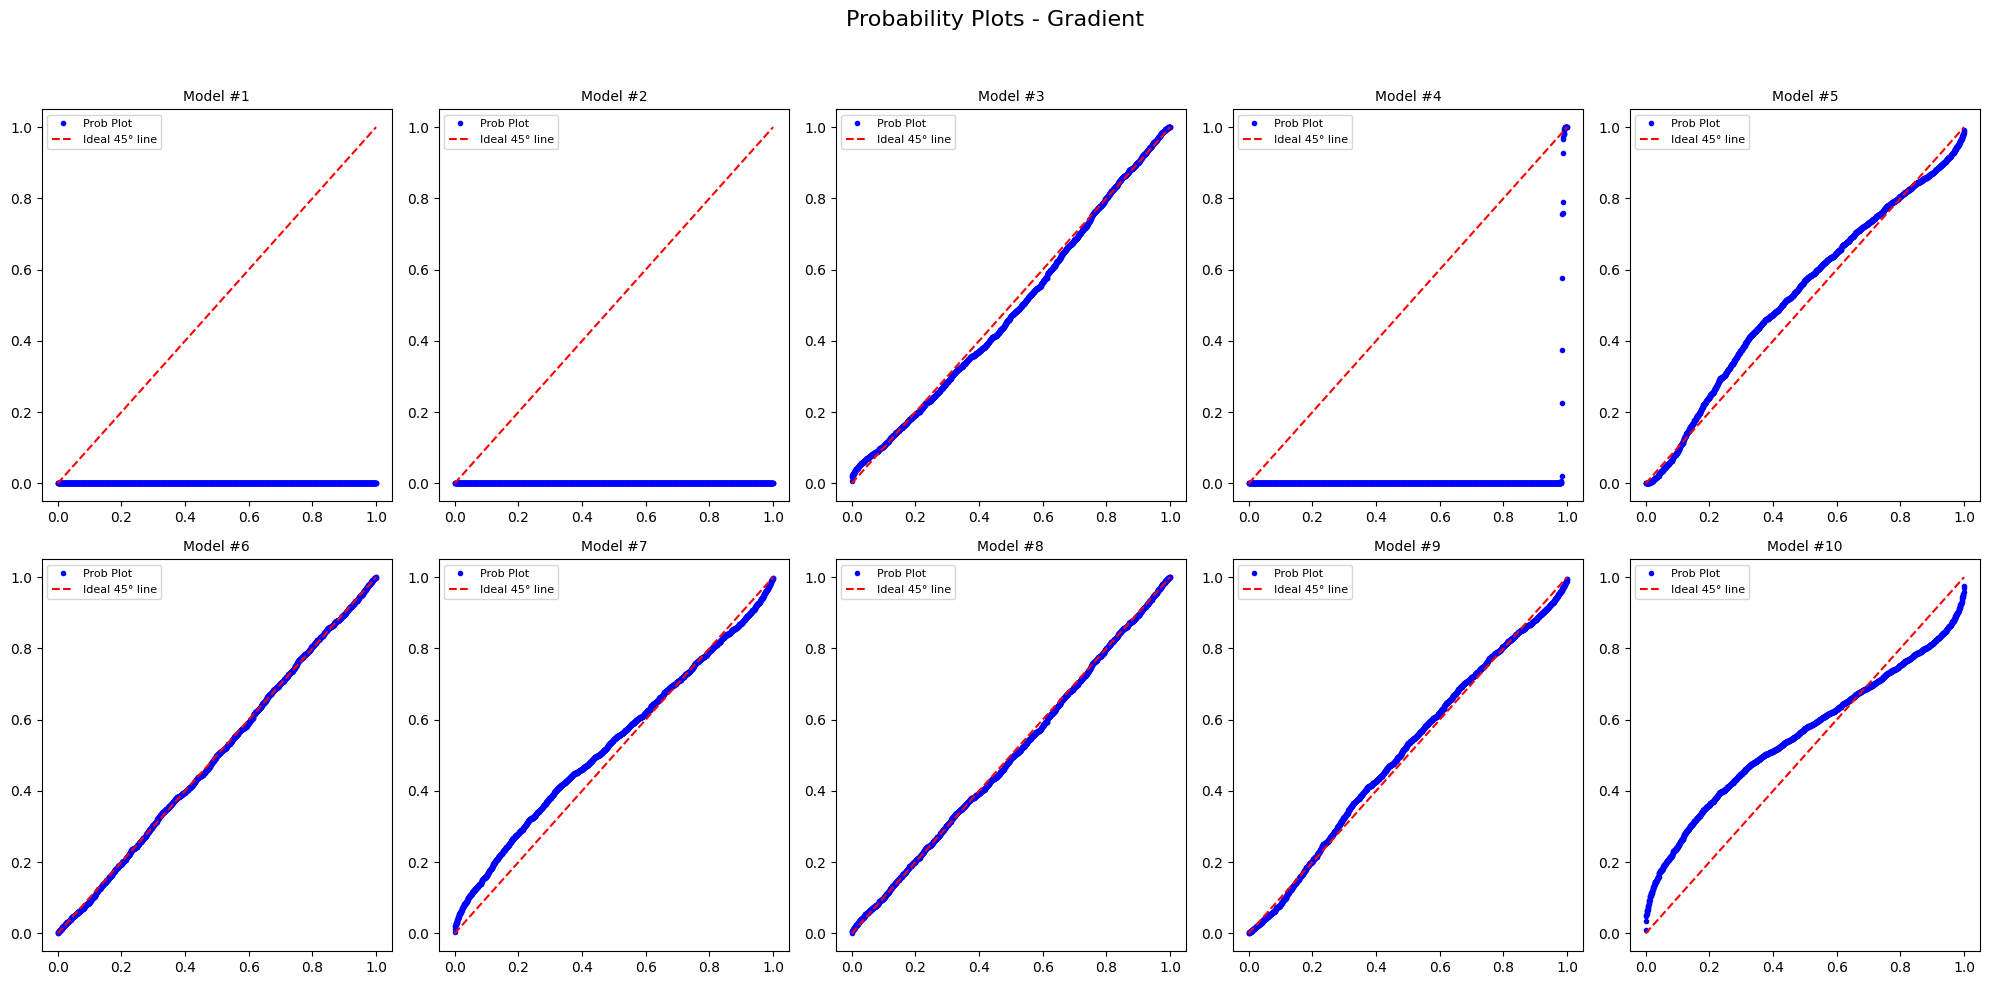

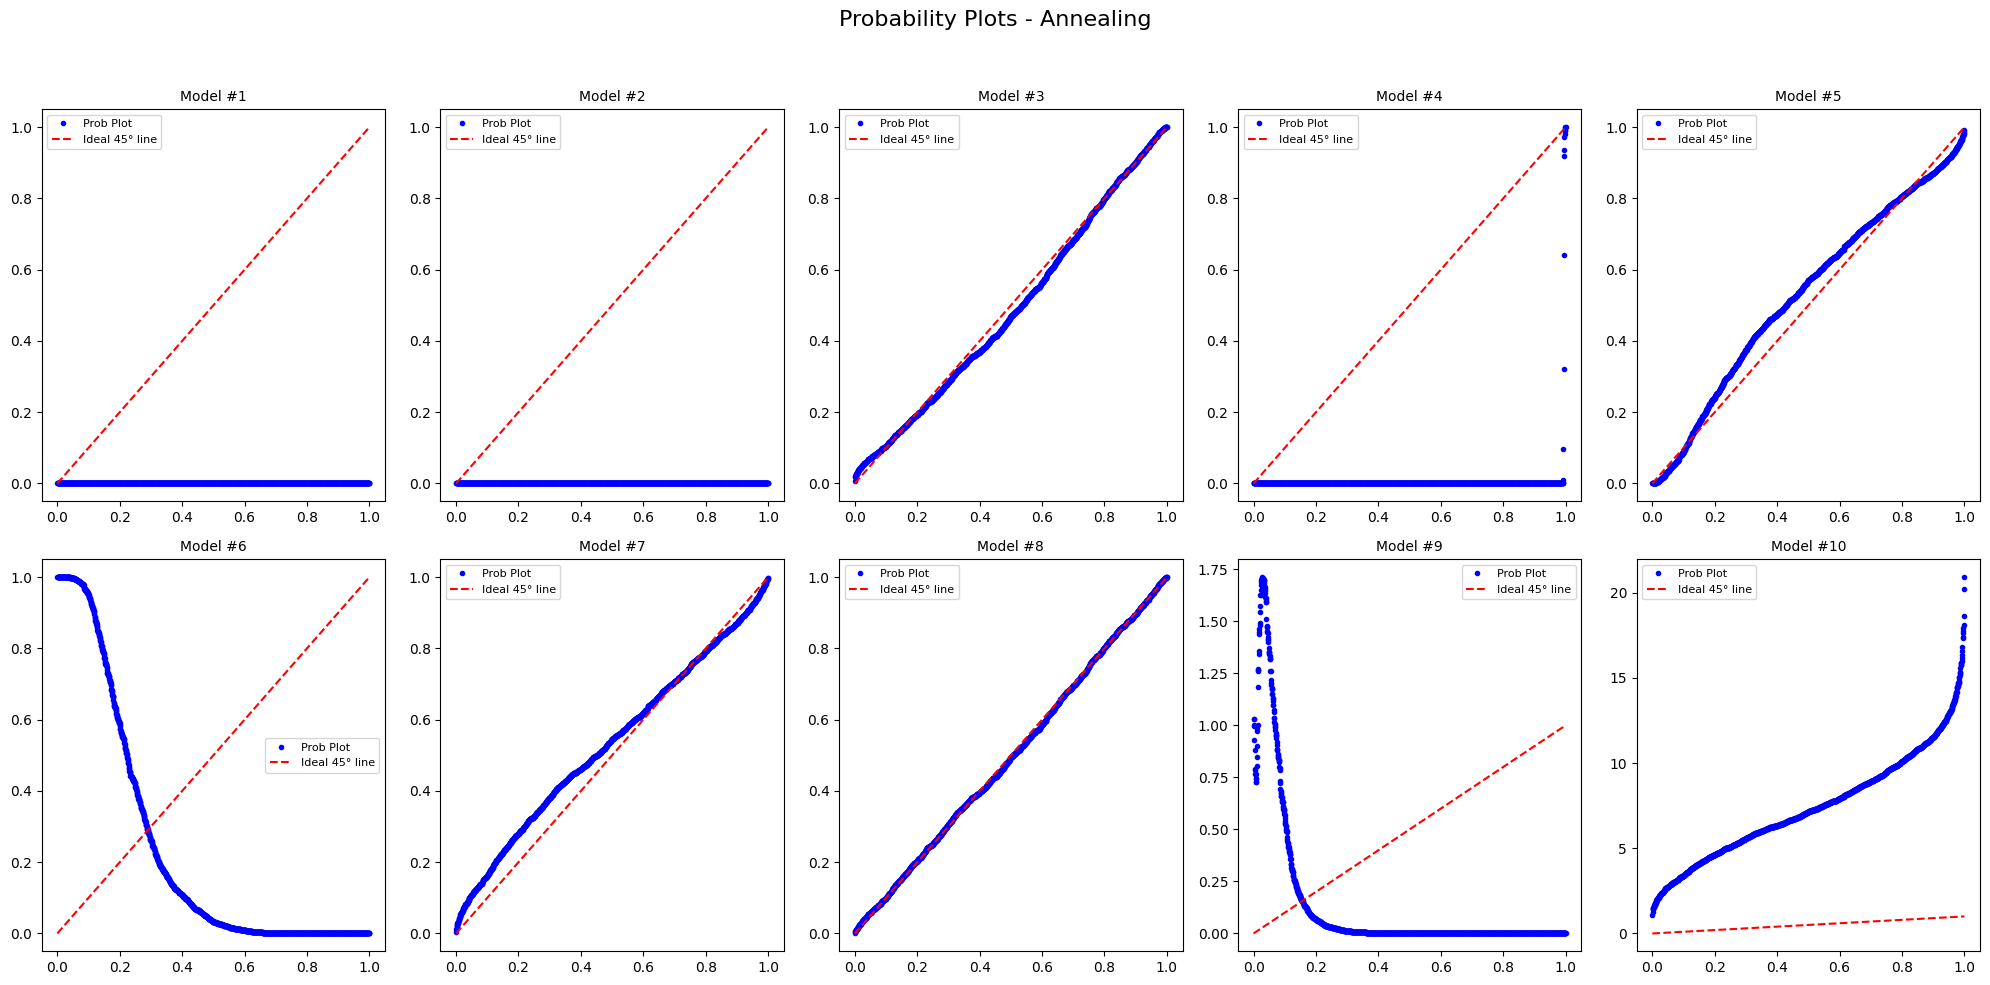

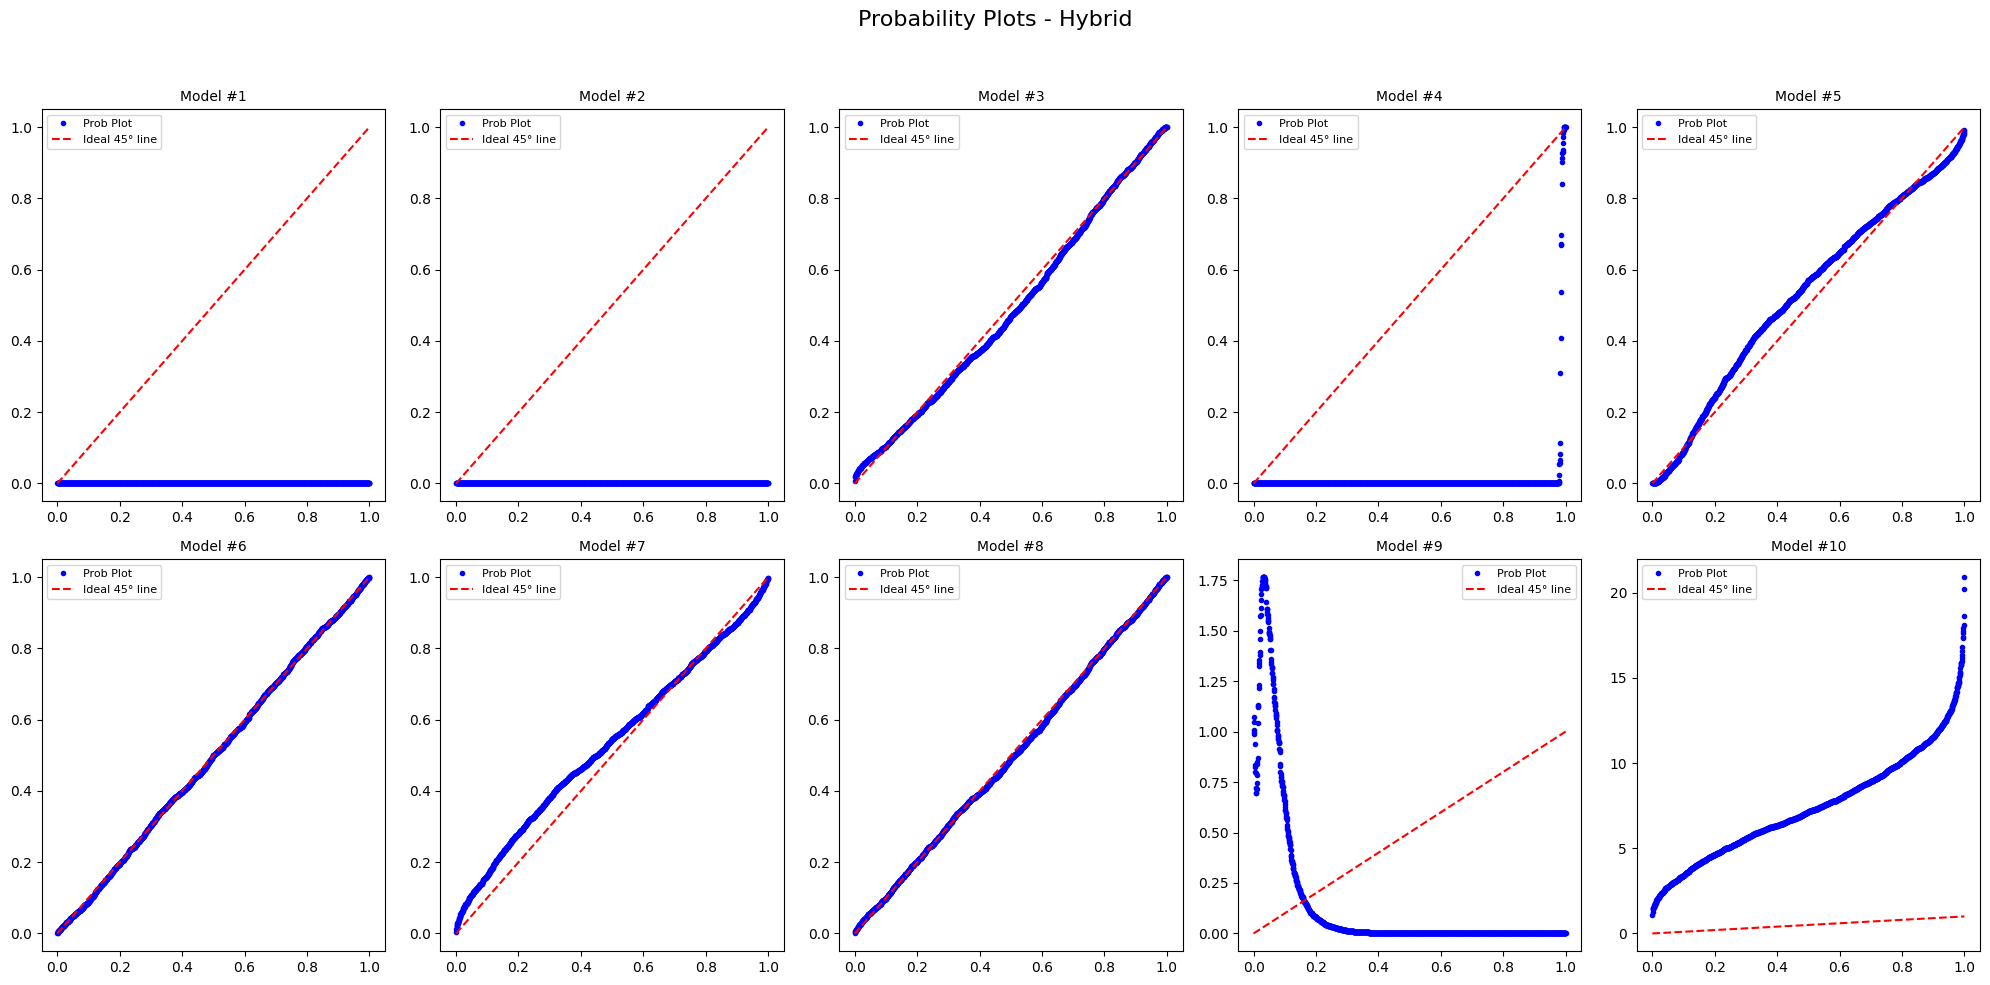

Plotted 3 sets of (2x5) Probability Plots. Total 30 graphs.


In [ ]:
##############################################
# Snippet I: PLOT PROBABILITY PLOTS FOR EACH METHOD
##############################################

def numeric_cdf(pdf_func, x, params, n_steps=200):
    if x <= 0:
        return 0.0
    xs = np.linspace(0, x, n_steps)
    # If params is None, skip
    if params is None:
        return 0.0
    vals = [pdf_func(xx, *params) for xx in xs]
    area = 0.0
    for i in range(n_steps - 1):
        area += 0.5 * (vals[i] + vals[i+1]) * (xs[i+1] - xs[i])
    return area

method_names = ["gradient","annealing", "hybrid"]

for method_idx, method in enumerate(method_names):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle(f"Probability Plots - {method.capitalize()}", fontsize=16)

    i = 0
    for mname in results:
        row = i // 5
        col = i % 5

        best_params, _ = results[mname][method]

        # Map model name to PDF
        # if "Model #1" in mname:
        #     pdf_ = pdf1
        # elif "Model #2" in mname:
        #     pdf_ = pdf2
        if "Model #3" in mname:
            pdf_ = pdf3
        elif "Model #4" in mname:
            pdf_ = pdf4
        elif "Model #5" in mname:
            pdf_ = pdf5
        elif "Model #6" in mname:
            pdf_ = pdf6
        elif "Model #7" in mname:
            pdf_ = pdf7
        elif "Model #8" in mname:
            pdf_ = pdf8
        elif "Model #9" in mname:
            pdf_ = pdf9
        elif "Model #10" in mname:
            pdf_ = pdf10
        else:
            print(f"Warning: No PDF matched for {mname}")
            pdf_ = None

        sorted_data = np.sort(data)
        n_ = len(sorted_data)

        if pdf_ is not None and best_params is not None:
            model_cdf_vals = []
            for x_val in sorted_data:
                cdf_val = numeric_cdf(pdf_, x_val, best_params)
                model_cdf_vals.append(cdf_val)
        else:
            model_cdf_vals = [0.0]*n_

        uniform_q = [(j + 0.5) / n_ for j in range(n_)]

        axs[row, col].plot(uniform_q, model_cdf_vals, 'bo', markersize=3, label='Prob Plot')
        axs[row, col].plot([0, 1], [0, 1], 'r--', label='Ideal 45° line')
        axs[row, col].set_title(mname, fontsize=10)
        axs[row, col].legend(fontsize=8)

        i += 1

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Plotted 3 sets of (2x5) Probability Plots. Total 30 graphs.")



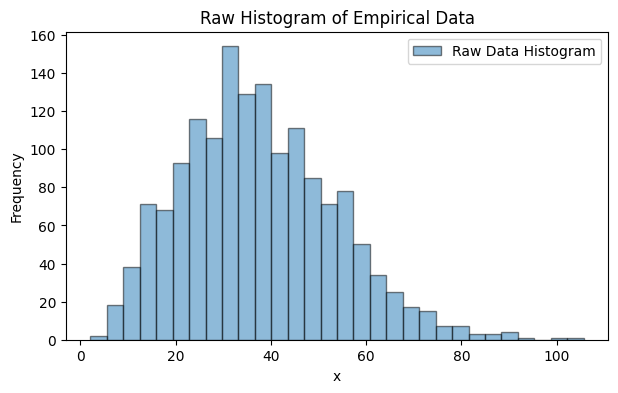

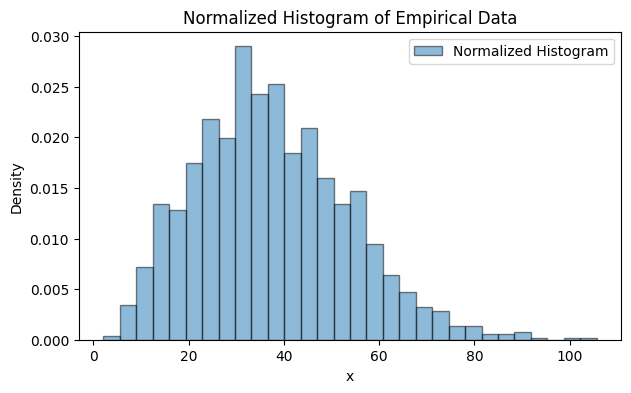

Data loaded. Number of points = 1540


In [ ]:
##############################################
# Snippet A: IMPORTS AND DATA LOADING
##############################################

import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# For SciPy optimization
from scipy.optimize import minimize

# For reproducibility in random sampling, bootstrapping, etc.
random.seed(123)
np.random.seed(123)

##############################################
# 1. LOAD DATA + PLOT HISTOGRAMS
##############################################

data_file = "data26002204680.csv"  # your CSV file path
data = []
with open(data_file, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        val = float(row[0])
        data.append(val)

data = np.array(data)
n = len(data)

# 1A. RAW HISTOGRAM
plt.figure(figsize=(7,4))
plt.hist(data, bins=30, alpha=0.5, edgecolor='k', label="Raw Data Histogram")
plt.title("Raw Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 1B. NORMALIZED HISTOGRAM
plt.figure(figsize=(7,4))
plt.hist(data, bins=30, density=True, alpha=0.5, edgecolor='k', label="Normalized Histogram")
plt.title("Normalized Histogram of Empirical Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Data loaded. Number of points = {n}")


In [ ]:
##############################################
# Snippet B: DEFINE 10 CANDIDATE PDFs (Improved)
##############################################
def pdf1(x, alpha, beta):
    """
    PDF1: Stabilized for edge cases with safeguards against invalid inputs.
    """
    if alpha <= 0 or beta <= 0 or x <= 0:
        return 1e-10
    try:
        denom = 2.0 * alpha * np.sqrt(2.0 * np.pi * beta) * (x ** 1.5)
        exponent = -((x - beta) ** 2) / (2.0 * (alpha ** 2) * beta * x)
        val = (np.exp(exponent) * (x + beta)) / denom
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf2(x, c, k, b):
    """
    PDF2: Generalized distribution with parameter safeguards.
    """
    if c <= 0 or k <= 0 or b <= 0 or x <= 0:
        return 1e-10
    try:
        numerator = (c * k) * (x ** (c * k - 1.0))
        denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
        if denominator <= 0:
            return 1e-10
        val = numerator / denominator
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf3(x, mu, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        coeff = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
        term1 = np.exp(-((x - mu) ** 2) / (2.0 * sigma ** 2))
        term2 = np.exp(-((x + mu) ** 2) / (2.0 * sigma ** 2))
        val = coeff * (term1 + term2)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf4(x, c, sigma):
    if c <= 0 or sigma <= 0 or x <= 0:
        return 1e-10
    try:
        val = (c / x) * ((x / sigma) ** (-c)) * np.exp(-((x / sigma) ** (-c)))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf5(x, lam, mu):
    if lam <= 0 or mu <= 0 or x <= 0:
        return 1e-10
    try:
        coeff = np.sqrt(lam / (2.0 * np.pi * (x ** 3)))
        exponent = -lam * ((x - mu) ** 2) / (2.0 * (mu ** 2) * x)
        val = coeff * np.exp(exponent)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf6(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        factor = np.sqrt(2.0 / np.pi) * (x ** 2) / (sigma ** 3)
        val = factor * np.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf7(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        val = (x / (sigma ** 2)) * np.exp(-(x ** 2) / (2.0 * sigma ** 2))
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf8(x, c, b):
    if c <= 0 or b <= 0 or x < 0:
        return 1e-10
    try:
        val = (c * (x ** (c - 1.0)) * np.exp(-((x ** c) / (b ** c)))) / (b ** c)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf9(x, lam, mu):
    if lam <= 0 or mu <= 0 or x < 0:
        return 1e-10
    try:
        expr1 = np.exp(-x * lam)
        expr2 = expr1 * mu
        val = np.exp(-x * lam - expr2)
        bracket = lam * (1.0 + (1.0 - expr1) * mu)
        result = val * bracket
        return result if result > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

def pdf10(x, sigma):
    if sigma <= 0 or x < 0:
        return 1e-10
    try:
        const = ((sigma ** 2) * (1.0 + x)) / (1.0 + sigma)
        exponent = -x * sigma
        val = const * np.exp(exponent)
        return val if val > 0 else 1e-10
    except (OverflowError, ZeroDivisionError):
        return 1e-10

print("Improved PDFs defined.")

Improved PDFs defined.


In [ ]:
import math
import numpy as np
from scipy.optimize import minimize

##############################################
# Snippet D: NLL AND BASIC FIT (Gradient-based) FOR ALL MODELS
##############################################

# -------- Model #1 ---------------------------------------
def nll_1(params, data_array):
    alpha, beta = params
    # Safeguard: alpha,beta > 0
    if alpha <= 0 or beta <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf1(x, alpha, beta)
        if val <= 0:
            return np.inf  # invalid or zero PDF => infinite NLL
        total += -math.log(val)
    return total

def fit_pdf1_gradient(data_array):
    """
    Gradient-based fitting for Model #1.
    """
    init = [0.5, 33.0]  # Initial guesses
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_1(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #2 ---------------------------------------
def nll_2(params, data_array):
    c_, k_, b_ = params
    if c_ <= 0 or k_ <= 0 or b_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf2(x, c_, k_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf2_gradient(data_array):
    """
    Gradient-based fitting for Model #2.
    """
    init = [77.0, 78.0, 94.0]
    bnds = [(1e-6, None), (1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_2(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #3 ---------------------------------------
def nll_3(params, data_array):
    mu_, sigma_ = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf3(x, mu_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf3_gradient(data_array):
    """
    Gradient-based fitting for Model #3.
    """
    init = [37.0, 16.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_3(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #4 ---------------------------------------
def nll_4(params, data_array):
    c_, sigma_ = params
    if c_ <= 0 or sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf4(x, c_, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf4_gradient(data_array):
    """
    Gradient-based fitting for Model #4.
    """
    init = [20.0, 76.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_4(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #5 ---------------------------------------
def nll_5(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf5(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf5_gradient(data_array):
    """
    Gradient-based fitting for Model #5.
    """
    init = [138.0, 37.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_5(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #6 ---------------------------------------
def nll_6(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf6(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf6_gradient(data_array):
    """
    Gradient-based fitting for Model #6.
    """
    init = [23.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_6(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #7 ---------------------------------------
def nll_7(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf7(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf7_gradient(data_array):
    """
    Gradient-based fitting for Model #7.
    """
    init = [28.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_7(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #8 ---------------------------------------
def nll_8(params, data_array):
    c_, b_ = params
    if c_ <= 0 or b_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf8(x, c_, b_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf8_gradient(data_array):
    """
    Gradient-based fitting for Model #8.
    """
    init = [87.0, 67.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_8(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #9 ---------------------------------------
def nll_9(params, data_array):
    lam_, mu_ = params
    if lam_ <= 0 or mu_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf9(x, lam_, mu_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf9_gradient(data_array):
    """
    Gradient-based fitting for Model #9.
    """
    init = [84.0, 82.0]
    bnds = [(1e-6, None), (1e-6, None)]
    res = minimize(lambda p: nll_9(p, data_array), init, bounds=bnds)
    return res.x, res.fun


# -------- Model #10 --------------------------------------
def nll_10(params, data_array):
    (sigma_,) = params
    if sigma_ <= 0:
        return np.inf

    total = 0.0
    for x in data_array:
        val = pdf10(x, sigma_)
        if val <= 0:
            return np.inf
        total += -math.log(val)
    return total

def fit_pdf10_gradient(data_array):
    """
    Gradient-based fitting for Model #10.
    """
    init = [94.0]
    bnds = [(1e-6, None)]
    res = minimize(lambda p: nll_10(p, data_array), init, bounds=bnds)
    return res.x, res.fun

print("NLL functions and gradient-based fits for all 10 models defined (no upper bound).")


NLL functions and gradient-based fits for all 10 models defined (no upper bound).


In [ ]:
##############################################
# Snippet E: SIMULATED ANNEALING (SA)
##############################################

def simulated_annealing(nll_func, init_params, data_array,
                        max_iter=2000, temp_start=10.0, temp_end=0.1, alpha=0.99):
    """
    Very minimal SA approach.
    :nll_func: a function nll_func(params, data)
    :init_params: initial guess
    :data_array: the dataset
    :max_iter: number of iterations
    :temp_start: starting temperature
    :temp_end: end temperature
    :alpha: decay rate per iteration
    """
    import copy

    current_params = np.array(init_params, dtype=np.float64)
    current_nll = nll_func(current_params, data_array)
    best_params = copy.deepcopy(current_params)
    best_nll = current_nll

    temp = temp_start

    for i in range(max_iter):
        # Generate new candidate (slight random perturbation)
        candidate = current_params + np.random.normal(0, 1, size=len(current_params))

        # Clip or enforce positivity if needed
        # e.g. candidate = np.clip(candidate, 1e-6, 1e6)

        cand_nll = nll_func(candidate, data_array)

        # If better, accept immediately
        if cand_nll < current_nll:
            current_params = candidate
            current_nll = cand_nll
            if cand_nll < best_nll:
                best_params = candidate
                best_nll = cand_nll
        else:
            # Accept with probability exp(-(cand_nll - current_nll) / temp)
            diff = cand_nll - current_nll
            prob = math.exp(-diff / temp)
            if np.random.rand() < prob:
                current_params = candidate
                current_nll = cand_nll

        # Cool down
        temp = max(temp_end, temp * alpha)

    return best_params, best_nll

print("Defined a simple simulated annealing function.")


Defined a simple simulated annealing function.


In [ ]:
##############################################
# Snippet F: HYBRID (SA + Gradient)
##############################################

def fit_hybrid(nll_func, init_params, data_array):
    # 1) Run simulated annealing
    sa_params, sa_nll = simulated_annealing(nll_func, init_params, data_array,
                                           max_iter=1000,
                                           temp_start=10.0, temp_end=0.01, alpha=0.98)
    # 2) Then refine with gradient-based
    res = minimize(lambda p: nll_func(p, data_array), sa_params)
    return res.x, res.fun

print("Defined a hybrid approach (SA + gradient).")


Defined a hybrid approach (SA + gradient).


In [ ]:
##############################################
# Snippet G: MULTI-START GRADIENT
##############################################

def fit_pdf_multi_start(nll_func, data_array, param_dims, tries=5):
    """
    param_dims: e.g. [(0.1, 5), (0.1, 10)] for 2D (alpha in [0.1..5], beta in [0.1..10])
    tries: how many random starts
    """
    best_params = None
    best_nll = np.inf

    for _ in range(tries):
        init_guess = []
        for (low, high) in param_dims:
            init_guess.append(np.random.uniform(low, high))

        res = minimize(lambda p: nll_func(p, data_array), init_guess)
        if res.fun < best_nll:
            best_nll = res.fun
            best_params = res.x

    return best_params, best_nll

print("Defined multi-start approach for trying a range of initial values.")


Defined multi-start approach for trying a range of initial values.


In [ ]:
##############################################
# Snippet H: COMPARE THREE METHODS FOR ALL 10 MODELS
##############################################

def model_nll_funcs():
    return {
        "Model #1": (nll_1, [(1e-3, 100), (1e-3, 100)]),
        "Model #2": (nll_2, [(1e-3, 100), (1e-3, 100), (1e-3, 100)]),
        "Model #3": (nll_3, [(1e-3, 100), (1e-3, 100)]),
        "Model #4": (nll_4, [(1e-3, 100), (1e-3, 100)]),
        "Model #5": (nll_5, [(1e-3, 100), (1e-3, 100)]),
        "Model #6": (nll_6, [(1e-3, 100)]),
        "Model #7": (nll_7, [(1e-3, 100)]),
        "Model #8": (nll_8, [(1e-3, 100), (1e-3, 100)]),
        "Model #9": (nll_9, [(1e-3, 100), (1e-3, 100)]),
        "Model #10": (nll_10, [(1e-3, 100)]),
    }

results = {}
model_funcs = model_nll_funcs()

for mname in model_funcs:
    print(f"\nOptimizing {mname}...")
    nll_func, param_dims = model_funcs[mname]

    # (a) Gradient
    best_g, best_nll_g = fit_pdf_multi_start(nll_func, data, param_dims, tries=5)
    print(f"  Gradient: Best Params = {best_g}, NLL = {best_nll_g:.6f}")

    # (b) Simulated Annealing
    init_random = [np.random.uniform(low, high) for (low, high) in param_dims]
    best_sa, best_nll_sa = simulated_annealing(nll_func, init_random, data)
    print(f"  Annealing: Best Params = {best_sa}, NLL = {best_nll_sa:.6f}")

    # (c) Hybrid
    best_hyb, best_nll_hyb = fit_hybrid(nll_func, init_random, data)
    print(f"  Hybrid: Best Params = {best_hyb}, NLL = {best_nll_hyb:.6f}")

    results[mname] = {
        'gradient': (best_g, best_nll_g),
        'annealing': (best_sa, best_nll_sa),
        'hybrid': (best_hyb, best_nll_hyb)
    }

print("\nAll models optimized with Gradient, Annealing, and Hybrid methods.")



Optimizing Model #1...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df

  Gradient: Best Params = [ 0.50350699 33.16891762], NLL = 6503.951038
  Annealing: Best Params = [ 0.49786933 33.14941075], NLL = 6504.149029
  Hybrid: Best Params = [ 0.50350699 33.16891655], NLL = 6503.951038

Optimizing Model #2...
  Gradient: Best Params = [11.19014115 61.09189844 23.27239722], NLL = 35459.810432


<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k) * (x ** (c * k - 1.0))
<ipython-input-129-8d3c59ccf50d>:26: RuntimeWarning: overflow encountered in scalar power
  denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
<ipython-input-129-8d3c59ccf50d>:29: RuntimeWarning: invalid value encountered in scalar divide
  val = numerator / denominator


  Annealing: Best Params = [77.01281156 78.69048653 93.9848156 ], NLL = 35459.810432
  Hybrid: Best Params = [77.01281156 78.69048653 93.9848156 ], NLL = 35459.810432

Optimizing Model #3...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [37.33446817 16.14301847], NLL = 6443.366142
  Annealing: Best Params = [37.3685879  16.19326889], NLL = 6443.383406
  Hybrid: Best Params = [-37.33450888  16.14297053], NLL = 6443.366142

Optimizing Model #4...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [77.03030948 76.0755355 ], NLL = 36281.711451
  Annealing: Best Params = [57.40415522 83.83399408], NLL = 36079.220229
  Hybrid: Best Params = [48.89398809 75.92227609], NLL = 38413.248505

Optimizing Model #5...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [138.80566173  37.42047048], NLL = 6515.080102
  Annealing: Best Params = [138.82892018  37.42689335], NLL = 6515.080197
  Hybrid: Best Params = [138.82649777  37.42059358], NLL = 6515.080109

Optimizing Model #6...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [23.48376551], NLL = 6402.012895
  Annealing: Best Params = [0.04787467], NLL = 35459.810432
  Hybrid: Best Params = [23.48376402], NLL = 6402.012895

Optimizing Model #7...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [28.76162125], NLL = 6466.921604
  Annealing: Best Params = [28.76120105], NLL = 6466.921605
  Hybrid: Best Params = [28.76160691], NLL = 6466.921604

Optimizing Model #8...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df

  Gradient: Best Params = [ 2.50728143 42.20446826], NLL = 6407.276217
  Annealing: Best Params = [ 2.51184486 42.05077766], NLL = 6407.357267
  Hybrid: Best Params = [ 2.5072819 42.2044948], NLL = 6407.276217

Optimizing Model #9...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [0.0719021 7.4204882], NLL = 6428.489154
  Annealing: Best Params = [79.75681239 83.72842074], NLL = 46141.948892
  Hybrid: Best Params = [79.75868368 98.22186481], NLL = 46139.055849

Optimizing Model #10...


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  Gradient: Best Params = [0.05212287], NLL = 6710.794427
  Annealing: Best Params = [79.75722893], NLL = 46189.749538
  Hybrid: Best Params = [79.77305733], NLL = 46191.991874

All models optimized with Gradient, Annealing, and Hybrid methods.


<ipython-input-129-8d3c59ccf50d>:26: RuntimeWarning: overflow encountered in scalar power
  denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar multiply
  numerator = (c * k) * (x ** (c * k - 1.0))
<ipython-input-129-8d3c59ccf50d>:29: RuntimeWarning: invalid value encountered in scalar divide
  val = numerator / denominator
<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k) * (x ** (c * k - 1.0))


TypeError: pdf1() missing 1 required positional argument: 'beta'

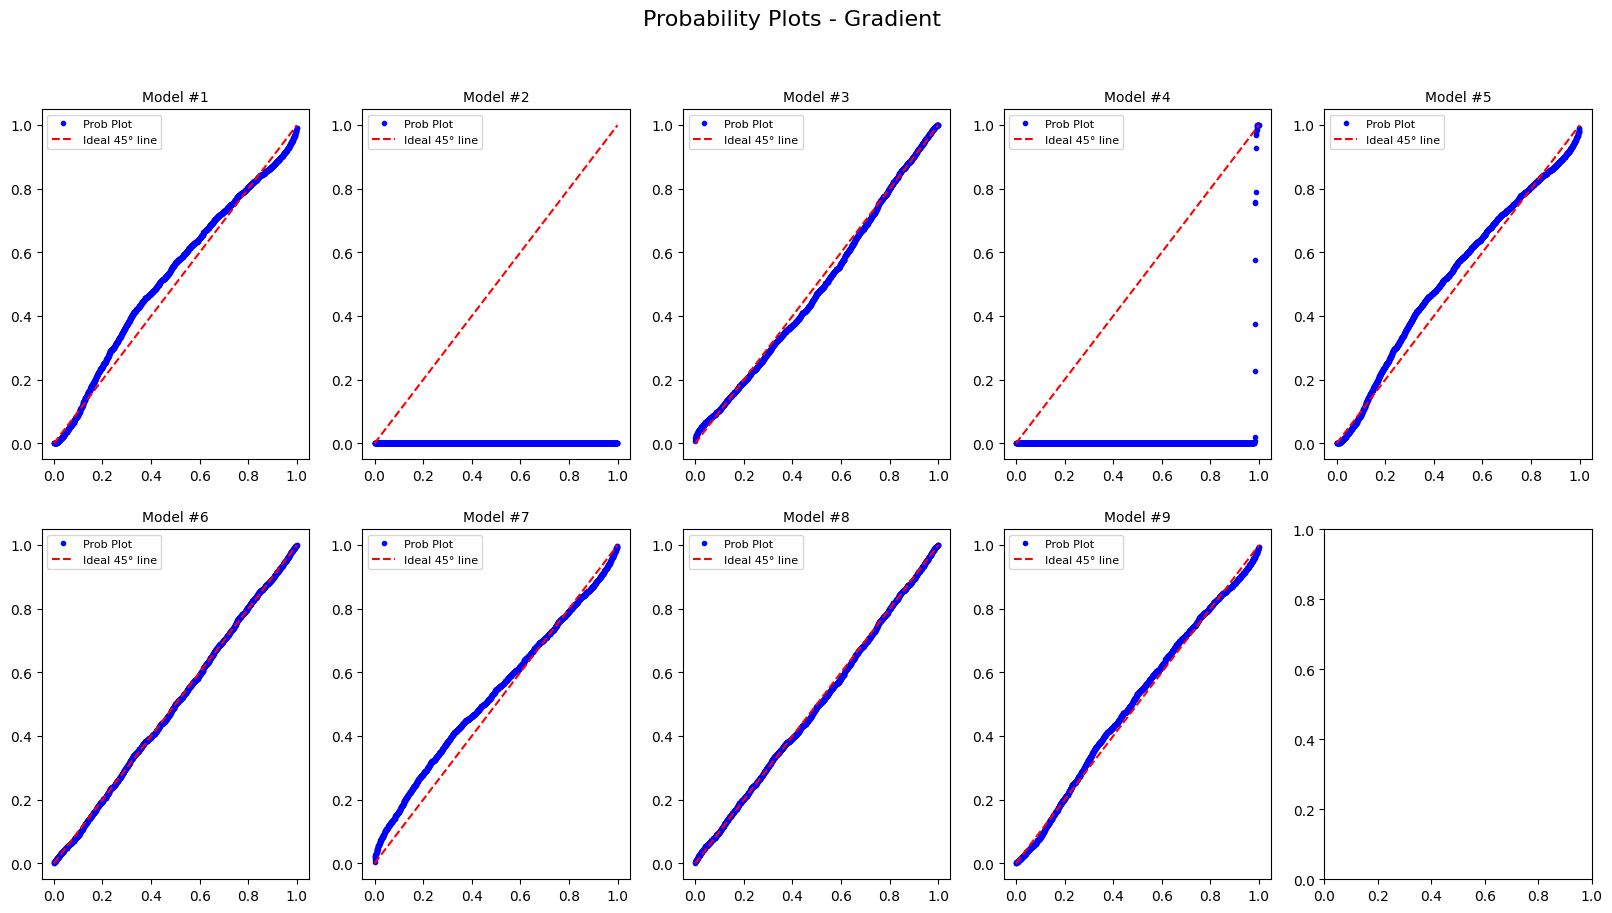

In [ ]:
##############################################
# Snippet I: PLOT PROBABILITY PLOTS FOR EACH METHOD
##############################################

def numeric_cdf(pdf_func, x, params, n_steps=200):
    if x <= 0:
        return 0.0
    xs = np.linspace(0, x, n_steps)
    # If params is None, skip
    if params is None:
        return 0.0
    vals = [pdf_func(xx, *params) for xx in xs]
    area = 0.0
    for i in range(n_steps - 1):
        area += 0.5 * (vals[i] + vals[i+1]) * (xs[i+1] - xs[i])
    return area

method_names = ["gradient","annealing", "hybrid"]

for method_idx, method in enumerate(method_names):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle(f"Probability Plots - {method.capitalize()}", fontsize=16)

    i = 0
    for mname in results:
        row = i // 5
        col = i % 5

        best_params, _ = results[mname][method]

        # Map model name to PDF
        if "Model #1" in mname:
            pdf_ = pdf1
        elif "Model #2" in mname:
            pdf_ = pdf2
        elif "Model #3" in mname:
            pdf_ = pdf3
        elif "Model #4" in mname:
            pdf_ = pdf4
        elif "Model #5" in mname:
            pdf_ = pdf5
        elif "Model #6" in mname:
            pdf_ = pdf6
        elif "Model #7" in mname:
            pdf_ = pdf7
        elif "Model #8" in mname:
            pdf_ = pdf8
        elif "Model #9" in mname:
            pdf_ = pdf9
        elif "Model #10" in mname:
            pdf_ = pdf10
        else:
            print(f"Warning: No PDF matched for {mname}")
            pdf_ = None

        sorted_data = np.sort(data)
        n_ = len(sorted_data)

        if pdf_ is not None and best_params is not None:
            model_cdf_vals = []
            for x_val in sorted_data:
                cdf_val = numeric_cdf(pdf_, x_val, best_params)
                model_cdf_vals.append(cdf_val)
        else:
            model_cdf_vals = [0.0]*n_

        uniform_q = [(j + 0.5) / n_ for j in range(n_)]

        axs[row, col].plot(uniform_q, model_cdf_vals, 'bo', markersize=3, label='Prob Plot')
        axs[row, col].plot([0, 1], [0, 1], 'r--', label='Ideal 45° line')
        axs[row, col].set_title(mname, fontsize=10)
        axs[row, col].legend(fontsize=8)

        i += 1

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Plotted 3 sets of (2x5) Probability Plots. Total 30 graphs.")



In [ ]:
import numpy as np
import math

##############################################
# Snippet J: KS TEST AND P-VALUES
##############################################

def ks_test(data_array, pdf_func, params, n_steps=200):
    """
    Perform the KS test by comparing empirical and model CDFs.
    """
    def cdf_func(x):
        return numeric_cdf(pdf_func, x, params, n_steps=n_steps)

    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)
    max_diff = 0.0

    for i, x_val in enumerate(sorted_data):
        F_emp = (i + 1) / n_  # Empirical CDF
        F_model = cdf_func(x_val)  # Model CDF
        diff = abs(F_emp - F_model)
        if diff > max_diff:
            max_diff = diff

    return max_diff

def ks_pvalue(ks_stat, sample_size):
    """
    Approximation for the p-value from the KS statistic.
    """
    n_ = sample_size
    p_approx = 2 * math.exp(-2 * (ks_stat ** 2) * n_)
    p_approx = min(max(p_approx, 0.0), 1.0)  # Clamp to [0, 1]
    return p_approx

print("\n=== KS TEST RESULTS (with more decimal places) ===")

for mname in results:
    for method in method_names:
        best_params, best_nll = results[mname][method]

        # Select the appropriate PDF function
        if "Model #1" in mname: pdf_ = pdf1
        elif "Model #2" in mname: pdf_ = pdf2
        elif "Model #3" in mname: pdf_ = pdf3
        elif "Model #4" in mname: pdf_ = pdf4
        elif "Model #5" in mname: pdf_ = pdf5
        elif "Model #6" in mname: pdf_ = pdf6
        elif "Model #7" in mname: pdf_ = pdf7
        elif "Model #8" in mname: pdf_ = pdf8
        elif "Model #9" in mname: pdf_ = pdf9
        elif "Model #10" in mname: pdf_ = pdf10

        # Perform KS test
        ks_stat = ks_test(data, pdf_, best_params)
        p_val = ks_pvalue(ks_stat, n)

        # Print KS statistics and p-value
        print(f"{mname} ({method}): KS={ks_stat:.6f}, p={p_val:.10f}")



In [ ]:
##############################################
# Snippet K: AIC/BIC FOR ALL (10) SOLUTIONS
##############################################

def compute_aic_bic(logL, num_params, sample_size):
    """
    Compute AIC and BIC scores.
    """
    AIC_ = 2 * num_params - 2 * logL
    BIC_ = num_params * math.log(sample_size) - 2 * logL
    return AIC_, BIC_

print("\n=== AIC/BIC RESULTS ===")

for mname in results:
    # Define parameter count based on model name
    if "Model #1" in mname: param_count = 2
    elif "Model #2" in mname: param_count = 3
    elif "Model #3" in mname: param_count = 2
    elif "Model #4" in mname: param_count = 2
    elif "Model #5" in mname: param_count = 2
    elif "Model #6" in mname: param_count = 1
    elif "Model #7" in mname: param_count = 1
    elif "Model #8" in mname: param_count = 2
    elif "Model #9" in mname: param_count = 2
    elif "Model #10" in mname: param_count = 1

    for method in method_names:
        best_params, best_nll = results[mname][method]
        logL = -best_nll  # Convert NLL to log-likelihood

        # Compute AIC and BIC
        AIC_, BIC_ = compute_aic_bic(logL, param_count, n)

        # Print AIC, BIC, and log-likelihood
        print(f"{mname} ({method}): AIC={AIC_:.4f}, BIC={BIC_:.4f}, logL={logL:.4f}")



=== AIC/BIC RESULTS ===
Model #1 (gradient): AIC=13011.9021, BIC=13022.5812, logL=-6503.9510
Model #1 (annealing): AIC=13012.2981, BIC=13022.9771, logL=-6504.1490
Model #1 (hybrid): AIC=13011.9021, BIC=13022.5812, logL=-6503.9510
Model #2 (gradient): AIC=70925.6209, BIC=70941.6395, logL=-35459.8104
Model #2 (annealing): AIC=70925.6209, BIC=70941.6395, logL=-35459.8104
Model #2 (hybrid): AIC=70925.6209, BIC=70941.6395, logL=-35459.8104
Model #3 (gradient): AIC=12890.7323, BIC=12901.4114, logL=-6443.3661
Model #3 (annealing): AIC=12890.7668, BIC=12901.4459, logL=-6443.3834
Model #3 (hybrid): AIC=12890.7323, BIC=12901.4114, logL=-6443.3661
Model #4 (gradient): AIC=72567.4229, BIC=72578.1020, logL=-36281.7115
Model #4 (annealing): AIC=72162.4405, BIC=72173.1195, logL=-36079.2202
Model #4 (hybrid): AIC=76830.4970, BIC=76841.1761, logL=-38413.2485
Model #5 (gradient): AIC=13034.1602, BIC=13044.8393, logL=-6515.0801
Model #5 (annealing): AIC=13034.1604, BIC=13044.8395, logL=-6515.0802
Model 

In [ ]:
##############################################
# Snippet L: WRAP-UP
##############################################

print("\nAll steps completed.")
print("We have 30 parameter sets (10 models × 3 methods).")
print("We have 30 probability plots in total (3 figures, each 2×5 subplots).")
print("We have KS test results (with p-values) and AIC/BIC for all solutions.")



All steps completed.
We have 30 parameter sets (10 models × 3 methods).
We have 30 probability plots in total (3 figures, each 2×5 subplots).
We have KS test results (with p-values) and AIC/BIC for all solutions.


In [ ]:
import numpy as np
import math

##############################################
# Snippet J: KS TEST AND P-VALUES
##############################################

def ks_test(data_array, pdf_func, params, n_steps=200):
    """
    Perform the KS test by comparing empirical and model CDFs.
    """
    def cdf_func(x):
        return numeric_cdf(pdf_func, x, params, n_steps=n_steps)

    sorted_data = np.sort(data_array)
    n_ = len(sorted_data)
    max_diff = 0.0

    for i, x_val in enumerate(sorted_data):
        F_emp = (i + 1) / n_  # Empirical CDF
        F_model = cdf_func(x_val)  # Model CDF
        diff = abs(F_emp - F_model)
        if diff > max_diff:
            max_diff = diff

    return max_diff

def ks_pvalue(ks_stat, sample_size):
    """
    Approximation for the p-value from the KS statistic.
    """
    n_ = sample_size
    p_approx = 2 * math.exp(-2 * (ks_stat ** 2) * n_)
    p_approx = min(max(p_approx, 0.0), 1.0)  # Clamp to [0, 1]
    return p_approx

print("\n=== KS TEST RESULTS (with more decimal places) ===")

for mname in results:
    for method in method_names:
        best_params, best_nll = results[mname][method]

        # Select the appropriate PDF function
        if "Model #1" in mname: pdf_ = pdf1
        elif "Model #2" in mname: pdf_ = pdf2
        elif "Model #3" in mname: pdf_ = pdf3
        elif "Model #4" in mname: pdf_ = pdf4
        elif "Model #5" in mname: pdf_ = pdf5
        elif "Model #6" in mname: pdf_ = pdf6
        elif "Model #7" in mname: pdf_ = pdf7
        elif "Model #8" in mname: pdf_ = pdf8
        elif "Model #9" in mname: pdf_ = pdf9
        elif "Model #10" in mname: pdf_ = pdf10

        # Perform KS test
        ks_stat = ks_test(data, pdf_, best_params)
        p_val = ks_pvalue(ks_stat, n)

        # Print KS statistics and p-value
        print(f"{mname} ({method}): KS={ks_stat:.6f}, p={p_val:.10f}")




=== KS TEST RESULTS (with more decimal places) ===
Model #1 (gradient): KS=0.082033, p=0.0000000020
Model #1 (annealing): KS=0.081505, p=0.0000000026
Model #1 (hybrid): KS=0.082033, p=0.0000000020


<ipython-input-129-8d3c59ccf50d>:26: RuntimeWarning: overflow encountered in scalar power
  denominator = (b ** (c * k)) * ((1.0 + (x ** c) / (b ** c)) ** (k + 1.0))
<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar multiply
  numerator = (c * k) * (x ** (c * k - 1.0))
<ipython-input-129-8d3c59ccf50d>:29: RuntimeWarning: invalid value encountered in scalar divide
  val = numerator / denominator
<ipython-input-129-8d3c59ccf50d>:25: RuntimeWarning: overflow encountered in scalar power
  numerator = (c * k) * (x ** (c * k - 1.0))


Model #2 (gradient): KS=1.000000, p=0.0000000000
Model #2 (annealing): KS=1.000000, p=0.0000000000
Model #2 (hybrid): KS=1.000000, p=0.0000000000
Model #3 (gradient): KS=0.040175, p=0.0138710176
Model #3 (annealing): KS=0.040739, p=0.0120516290
Model #3 (hybrid): KS=0.040176, p=0.0138667963
Model #4 (gradient): KS=0.979740, p=0.0000000000
Model #4 (annealing): KS=0.991043, p=0.0000000000
Model #4 (hybrid): KS=0.976413, p=0.0000000000
Model #5 (gradient): KS=0.084573, p=0.0000000005
Model #5 (annealing): KS=0.084440, p=0.0000000006
Model #5 (hybrid): KS=0.084551, p=0.0000000005
Model #6 (gradient): KS=0.012789, p=1.0000000000
Model #6 (annealing): KS=1.000000, p=0.0000000000
Model #6 (hybrid): KS=0.012789, p=1.0000000000
Model #7 (gradient): KS=0.085369, p=0.0000000004
Model #7 (annealing): KS=0.085377, p=0.0000000004
Model #7 (hybrid): KS=0.085370, p=0.0000000004
Model #8 (gradient): KS=0.021182, p=0.5021636855
Model #8 (annealing): KS=0.017968, p=0.7399453072
Model #8 (hybrid): KS=0.0

TypeError: pdf1() missing 1 required positional argument: 'beta'

In [ ]:
##############################################
# Snippet K: AIC/BIC FOR ALL (10) SOLUTIONS
##############################################

def compute_aic_bic(logL, num_params, sample_size):
    """
    Compute AIC and BIC scores.
    """
    AIC_ = 2 * num_params - 2 * logL
    BIC_ = num_params * math.log(sample_size) - 2 * logL
    return AIC_, BIC_

print("\n=== AIC/BIC RESULTS ===")

for mname in results:
    # Define parameter count based on model name
    if "Model #1" in mname: param_count = 2
    elif "Model #2" in mname: param_count = 3
    elif "Model #3" in mname: param_count = 2
    elif "Model #4" in mname: param_count = 2
    elif "Model #5" in mname: param_count = 2
    elif "Model #6" in mname: param_count = 1
    elif "Model #7" in mname: param_count = 1
    elif "Model #8" in mname: param_count = 2
    elif "Model #9" in mname: param_count = 2
    elif "Model #10" in mname: param_count = 1

    for method in method_names:
        best_params, best_nll = results[mname][method]
        logL = -best_nll  # Convert NLL to log-likelihood

        # Compute AIC and BIC
        AIC_, BIC_ = compute_aic_bic(logL, param_count, n)

        # Print AIC, BIC, and log-likelihood
        print(f"{mname} ({method}): AIC={AIC_:.4f}, BIC={BIC_:.4f}, logL={logL:.4f}")


In [ ]:
##############################################
# Snippet L: WRAP-UP
##############################################

print("\nAll steps completed.")
print("We have 30 parameter sets (10 models × 3 methods).")
print("We have 30 probability plots in total (3 figures, each 2×5 subplots).")
print("We have KS test results (with p-values) and AIC/BIC for all solutions.")
